In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# import shutil

# source_folder = '/content/drive/MyDrive/cyclegans/preprocess'
# destination_folder = '/content/drive/MyDrive/cyclegans_new/preprocess'

# shutil.copytree(source_folder, destination_folder)


'/content/drive/MyDrive/cyclegans_new/preprocess'

In [ ]:
# !mkdir -p '/content/drive/MyDrive/cyclegans_new/preprocess'

In [ ]:
# !rm -r /content/drive/MyDrive/cyclegans_new


In [ ]:
# # Change this path to where you want your project to live in Google Drive
# %cd /content/drive/MyDrive/cyclegans_new/

# # Clone the repo and install dependencies
# !git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git
# %cd pytorch-CycleGAN-and-pix2pix/
# !pip install -r requirements.txt

/content/drive/MyDrive/cyclegans_new
Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2516, done.
remote: Total 2516 (delta 0), reused 0 (delta 0), pack-reused 2516 (from 1)
Receiving objects: 100% (2516/2516), 8.20 MiB | 11.06 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
/content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

# PERCEPTUAL LOSS FUNCTION

In [ ]:
# Read the existing networks.py file
with open('models/networks.py', 'r') as f:
    original_content = f.read()

# Define the new VGGPerceptualLoss class
perceptual_loss_code = """
import torch
import torch.nn as nn
from torchvision import models

class VGGPerceptualLoss(nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(models.vgg19(pretrained=True).features[:4].eval())
        blocks.append(models.vgg19(pretrained=True).features[4:9].eval())
        blocks.append(models.vgg19(pretrained=True).features[9:18].eval())
        blocks.append(models.vgg19(pretrained=True).features[18:27].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
        self.blocks = nn.ModuleList(blocks)
        self.transform = nn.functional.interpolate
        self.resize = resize
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, input, target):
        # VGG expects 3 channels. If input is grayscale, repeat the channel.
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        # De-normalize from [-1, 1] to [0, 1]
        input = (input + 1) / 2
        target = (target + 1) / 2
        # Normalize for VGG
        input = (input - self.mean) / self.std
        target = (target - self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += nn.functional.l1_loss(x, y)
        return loss
"""

# Append the new class to the original content and overwrite the file
with open('models/networks.py', 'w') as f:
    f.write(original_content + "\n" + perceptual_loss_code)

print("✅ Appended VGGPerceptualLoss to models/networks.py")
print("Note: The first time you train, PyTorch will download the VGG19 model weights.")

✅ Appended VGGPerceptualLoss to models/networks.py
Note: The first time you train, PyTorch will download the VGG19 model weights.


In [ ]:
%%writefile models/cycle_gan_model.py
import torch
import itertools
from util.image_pool import ImagePool
from .base_model import BaseModel
from . import networks


class CycleGANModel(BaseModel):
    @staticmethod
    def modify_commandline_options(parser, is_train=True):
        parser.set_defaults(no_dropout=True)
        if is_train:
            parser.add_argument('--lambda_A', type=float, default=10.0, help='weight for cycle loss (A -> B -> A)')
            parser.add_argument('--lambda_B', type=float, default=10.0, help='weight for cycle loss (B -> A -> B)')
            parser.add_argument('--lambda_identity', type=float, default=0.5, help='use identity mapping.')
            # Add a new flag for our perceptual loss
            parser.add_argument('--lambda_perceptual', type=float, default=1.0, help='weight for perceptual loss')
        return parser

    def __init__(self, opt):
        BaseModel.__init__(self, opt)
        # Add 'perceptual' to the list of losses to log
        self.loss_names = ['D_A', 'G_A', 'cycle_A', 'idt_A', 'D_B', 'G_B', 'cycle_B', 'idt_B', 'perceptual']
        visual_names_A = ['real_A', 'fake_B', 'rec_A']
        visual_names_B = ['real_B', 'fake_A', 'rec_B']
        self.visual_names = visual_names_A + visual_names_B
        self.model_names = ['G_A', 'G_B', 'D_A', 'D_B']
        self.netG_A = networks.define_G(opt.input_nc, opt.output_nc, opt.ngf, opt.netG, opt.norm,
                                        not opt.no_dropout, opt.init_type, opt.init_gain, self.gpu_ids)
        self.netG_B = networks.define_G(opt.output_nc, opt.input_nc, opt.ngf, opt.netG, opt.norm,
                                        not opt.no_dropout, opt.init_type, opt.init_gain, self.gpu_ids)

        if self.isTrain:
            self.netD_A = networks.define_D(opt.output_nc, opt.ndf, opt.netD,
                                            opt.n_layers_D, opt.norm, opt.init_type, opt.init_gain, self.gpu_ids)
            self.netD_B = networks.define_D(opt.input_nc, opt.ndf, opt.netD,
                                            opt.n_layers_D, opt.norm, opt.init_type, opt.init_gain, self.gpu_ids)
            self.fake_A_pool = ImagePool(opt.pool_size)
            self.fake_B_pool = ImagePool(opt.pool_size)
            # define loss functions
            self.criterionGAN = networks.GANLoss(opt.gan_mode).to(self.device)
            self.criterionCycle = torch.nn.L1Loss()
            self.criterionIdt = torch.nn.L1Loss()
            # Initialize the perceptual loss
            self.criterionPerceptual = networks.VGGPerceptualLoss().to(self.device)
            # initialize optimizers
            self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A.parameters(), self.netG_B.parameters()), lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizer_D = torch.optim.Adam(itertools.chain(self.netD_A.parameters(), self.netD_B.parameters()), lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizers.append(self.optimizer_G)
            self.optimizers.append(self.optimizer_D)

    def set_input(self, input):
        AtoB = self.opt.direction == 'AtoB'
        self.real_A = input['A' if AtoB else 'B'].to(self.device)
        self.real_B = input['B' if AtoB else 'A'].to(self.device)
        self.image_paths = input['A_paths' if AtoB else 'B_paths']

    def forward(self):
        """Run forward pass"""
        self.fake_B = self.netG_A(self.real_A)
        self.rec_A = self.netG_B(self.fake_B)
        self.fake_A = self.netG_B(self.real_B)
        self.rec_B = self.netG_A(self.fake_A)

    def backward_D_basic(self, netD, real, fake):
        pred_real = netD(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        pred_fake = netD(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        return loss_D

    def backward_D_A(self):
        fake_B = self.fake_B_pool.query(self.fake_B)
        self.loss_D_A = self.backward_D_basic(self.netD_A, self.real_B, fake_B)

    def backward_D_B(self):
        fake_A = self.fake_A_pool.query(self.fake_A)
        self.loss_D_B = self.backward_D_basic(self.netD_B, self.real_A, fake_A)

    def backward_G(self):
        lambda_idt = self.opt.lambda_identity
        lambda_A = self.opt.lambda_A
        lambda_B = self.opt.lambda_B
        lambda_perceptual = self.opt.lambda_perceptual

        # Identity loss
        self.loss_idt_A = 0
        self.loss_idt_B = 0
        if lambda_idt > 0:
            self.idt_A = self.netG_A(self.real_B)
            self.loss_idt_A = self.criterionIdt(self.idt_A, self.real_B) * lambda_B * lambda_idt
            self.idt_B = self.netG_B(self.real_A)
            self.loss_idt_B = self.criterionIdt(self.idt_B, self.real_A) * lambda_A * lambda_idt

        # GAN loss
        self.loss_G_A = self.criterionGAN(self.netD_A(self.fake_B), True)
        self.loss_G_B = self.criterionGAN(self.netD_B(self.fake_A), True)
        # Cycle loss
        self.loss_cycle_A = self.criterionCycle(self.rec_A, self.real_A) * lambda_A
        self.loss_cycle_B = self.criterionCycle(self.rec_B, self.real_B) * lambda_B

        # --- NEW: Perceptual Loss Calculation ---
        # Compare real and reconstructed images in both directions
        self.loss_perceptual_A = self.criterionPerceptual(self.rec_A, self.real_A) * lambda_A * lambda_perceptual
        self.loss_perceptual_B = self.criterionPerceptual(self.rec_B, self.real_B) * lambda_B * lambda_perceptual
        self.loss_perceptual = self.loss_perceptual_A + self.loss_perceptual_B
        # --- END NEW ---

        # Combine all losses and calculate gradients
        self.loss_G = (self.loss_G_A + self.loss_G_B + self.loss_cycle_A + self.loss_cycle_B +
                       self.loss_idt_A + self.loss_idt_B + self.loss_perceptual)
        self.loss_G.backward()

    def optimize_parameters(self):
        self.forward()
        self.set_requires_grad([self.netD_A, self.netD_B], False)
        self.optimizer_G.zero_grad()
        self.backward_G()
        self.optimizer_G.step()
        self.set_requires_grad([self.netD_A, self.netD_B], True)
        self.optimizer_D.zero_grad()
        self.backward_D_A()
        self.backward_D_B()
        self.optimizer_D.step()

print("✅ Patched cycle_gan_model.py with Perceptual Loss.")

Overwriting models/cycle_gan_model.py


In [ ]:
%%writefile data/unaligned_npy_dataset.py
import os
import torch
import numpy as np
from data.base_dataset import BaseDataset

class UnalignedNpyDataset(BaseDataset):
    """This dataset class can load unaligned/unpaired datasets of .npy files."""
    def __init__(self, opt):
        BaseDataset.__init__(self, opt)
        self.dir_A = os.path.join(opt.dataroot, 'trainA')
        self.dir_B = os.path.join(opt.dataroot, 'trainB')

        self.A_paths = sorted([os.path.join(self.dir_A, f) for f in os.listdir(self.dir_A) if f.endswith('.npy')])
        self.B_paths = sorted([os.path.join(self.dir_B, f) for f in os.listdir(self.dir_B) if f.endswith('.npy')])
        self.A_size = len(self.A_paths)
        self.B_size = len(self.B_paths)

    def __getitem__(self, index):
        A_path = self.A_paths[index % self.A_size]
        index_B = np.random.randint(0, self.B_size - 1)
        B_path = self.B_paths[index_B]

        A_npy = np.load(A_path).astype(np.float32)
        B_npy = np.load(B_path).astype(np.float32)

        A_tensor = torch.from_numpy(A_npy.transpose((2, 0, 1)))
        B_tensor = torch.from_numpy(B_npy.transpose((2, 0, 1)))

        return {'A': A_tensor, 'B': B_tensor, 'A_paths': A_path, 'B_paths': B_path}

    def __len__(self):
        return max(self.A_size, self.B_size)

Writing data/unaligned_npy_dataset.py


In [ ]:
import re

# Read the existing networks.py file
with open('models/networks.py', 'r') as f:
    original_content = f.read()

# Remove the old, buggy VGGPerceptualLoss class definition if it exists
# This makes the script safe to run multiple times
cleaned_content = re.sub(r'class VGGPerceptualLoss.*', '', original_content, flags=re.DOTALL)

# Define the new, corrected VGGPerceptualLoss class
corrected_perceptual_loss_code = """
import torch
import torch.nn as nn
from torchvision import models

class VGGPerceptualLoss(nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(models.vgg19(pretrained=True).features[:4].eval())
        blocks.append(models.vgg19(pretrained=True).features[4:9].eval())
        blocks.append(models.vgg19(pretrained=True).features[9:18].eval())
        blocks.append(models.vgg19(pretrained=True).features[18:27].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
        self.blocks = nn.ModuleList(blocks)
        self.transform = nn.functional.interpolate
        self.resize = resize
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, input, target, feature_layers=[0, 1, 2, 3], style_layers=[]):
        # --- START OF FIX ---
        # Handle inputs with different channel numbers correctly
        if input.shape[1] == 1: # Grayscale
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        elif input.shape[1] == 2: # 2-Channel SAR Data
            # Use the first channel (e.g., VV) and repeat it to create a 3-channel grayscale image
            input = input[:, 0:1, :, :].repeat(1, 3, 1, 1)
            target = target[:, 0:1, :, :].repeat(1, 3, 1, 1)
        # --- END OF FIX ---

        # De-normalize from [-1, 1] to [0, 1]
        input = (input + 1) / 2
        target = (target + 1) / 2
        # Normalize for VGG
        input = (input - self.mean) / self.std
        target = (target - self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += nn.functional.l1_loss(x, y)
        return loss
"""

# Append the new class to the cleaned content and overwrite the file
with open('models/networks.py', 'w') as f:
    f.write(cleaned_content + "\n" + corrected_perceptual_loss_code)

print("✅ Corrected the VGGPerceptualLoss class in models/networks.py")

✅ Corrected the VGGPerceptualLoss class in models/networks.py


In [ ]:
%%writefile util/util.py
"""This module contains simple helper functions """
from __future__ import print_function
import torch
import numpy as np
from PIL import Image
import os


def tensor2im(input_image, imtype=np.uint8):
    """"Converts a Tensor array into a numpy image array."""
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor[0].cpu().float().numpy()

        # --- START OF FIX ---
        # Handle inputs with different channel numbers correctly for visualization
        if image_numpy.ndim == 2:  # Handle 2D arrays
            image_numpy = np.expand_dims(image_numpy, axis=0)
        if image_numpy.shape[0] == 1:  # Grayscale
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        elif image_numpy.shape[0] == 2:  # 2-Channel SAR
            image_numpy = np.tile(image_numpy[0:1, :, :], (3, 1, 1))
        # --- END OF FIX ---

        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    else:
        image_numpy = input_image
    return image_numpy.astype(imtype)


def save_image(image_numpy, image_path, aspect_ratio=1.0):
    """Save a numpy image to the disk"""
    image_pil = Image.fromarray(image_numpy)
    h, w, _ = image_numpy.shape
    if aspect_ratio > 1.0:
        image_pil = image_pil.resize((h, int(w * aspect_ratio)), Image.BICUBIC)
    if aspect_ratio < 1.0:
        image_pil = image_pil.resize((int(h / aspect_ratio), w), Image.BICUBIC)
    image_pil.save(image_path)


def mkdirs(paths):
    """create empty directories if they don't exist"""
    if isinstance(paths, list) and not isinstance(paths, str):
        for path in paths:
            mkdir(path)
    else:
        mkdir(paths)


def mkdir(path):
    """create a single empty directory if it doesn't exist"""
    if not os.path.exists(path):
        os.makedirs(path)

Overwriting util/util.py


In [ ]:
!python train.py \
  --dataroot /content/drive/MyDrive/cyclegans_new/preprocess/sar_to_rgb/ \
  --name sar2rgb_perceptual \
  --model cycle_gan \
  --netG resnet_9blocks \
  --dataset_mode unaligned_npy \
  --input_nc 2 \
  --output_nc 3 \
  --no_flip \
  --lambda_identity 0 \
  --lr 0.0001 \
  --lambda_perceptual 1.0
  --continue_train \
  --epoch_count 11



✅ Patched cycle_gan_model.py with Perceptual Loss.
----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/cyclegans_new/preprocess/sar_to_rgb/	[default: None]
             dataset_mode: unaligned_npy                 	[default: unaligned]
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 25

In [ ]:
# --- ⚙️ CONFIGURATION ---
# 1. The name of your new training experiment folder.
EXPERIMENT_NAME = 'sar2rgb_perceptual'

# 2. The epoch number you want to evaluate.
EPOCH_TO_TEST = '10'

# 3. The generator architecture you used for training.
NET_G = 'resnet_9blocks'
# --- END CONFIGURATION ---

# Navigate to the project directory first
%cd /content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix/

# Construct and run the test command
!python test.py \
  --dataroot "/content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix/test_data/sar_input" \
  --name {EXPERIMENT_NAME} \
  --model cycle_gan \
  --netG {NET_G} \
  --dataset_mode single_npy \
  --input_nc 2 \
  --output_nc 3 \
  --no_flip \
  --epoch {EPOCH_TO_TEST} \
  --eval


/content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix
✅ Dataloader files for .npy format have been created/patched.
----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix/test_data/sar_input	[default: None]
             dataset_mode: single_npy                    	[default: unaligned]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: 10                            	[default: latest]
                     eval: True                          	[default: False]
                  gpu_ids: 0                             
                init_gain: 0.02                          
       

In [ ]:
%%writefile models/cycle_gan_model.py
import torch
import itertools
from util.image_pool import ImagePool
from .base_model import BaseModel
from . import networks


class CycleGANModel(BaseModel):
    @staticmethod
    def modify_commandline_options(parser, is_train=True):
        parser.set_defaults(no_dropout=True)
        if is_train:
            parser.add_argument('--lambda_A', type=float, default=10.0, help='weight for cycle loss (A -> B -> A)')
            parser.add_argument('--lambda_B', type=float, default=10.0, help='weight for cycle loss (B -> A -> B)')
            parser.add_argument('--lambda_identity', type=float, default=0.5, help='use identity mapping.')
        return parser

    def __init__(self, opt):
        BaseModel.__init__(self, opt)

        # --- START OF FIX ---
        # Make the model and visual names conditional on whether we are training or testing
        if self.isTrain:
            self.loss_names = ['D_A', 'G_A', 'cycle_A', 'idt_A', 'D_B', 'G_B', 'cycle_B', 'idt_B']
            visual_names_A = ['real_A', 'fake_B', 'rec_A']
            visual_names_B = ['real_B', 'fake_A', 'rec_B']
            if self.opt.lambda_identity > 0.0:
                visual_names_A.append('idt_B')
                visual_names_B.append('idt_A')
            self.visual_names = visual_names_A + visual_names_B
            self.model_names = ['G_A', 'G_B', 'D_A', 'D_B']
        else:  # during test time, only show relevant images and load Gs
            self.visual_names = ['real_A', 'fake_B']
            self.model_names = ['G_A', 'G_B']
        # --- END OF FIX ---

        self.netG_A = networks.define_G(opt.input_nc, opt.output_nc, opt.ngf, opt.netG, opt.norm,
                                        not opt.no_dropout, opt.init_type, opt.init_gain, self.gpu_ids)
        self.netG_B = networks.define_G(opt.output_nc, opt.input_nc, opt.ngf, opt.netG, opt.norm,
                                        not opt.no_dropout, opt.init_type, opt.init_gain, self.gpu_ids)

        if self.isTrain:
            self.netD_A = networks.define_D(opt.output_nc, opt.ndf, opt.netD,
                                            opt.n_layers_D, opt.norm, opt.init_type, opt.init_gain, self.gpu_ids)
            self.netD_B = networks.define_D(opt.input_nc, opt.ndf, opt.netD,
                                            opt.n_layers_D, opt.norm, opt.init_type, opt.init_gain, self.gpu_ids)
            if opt.lambda_identity > 0.0:
                assert(opt.input_nc == opt.output_nc)
            self.fake_A_pool = ImagePool(opt.pool_size)
            self.fake_B_pool = ImagePool(opt.pool_size)
            self.criterionGAN = networks.GANLoss(opt.gan_mode).to(self.device)
            self.criterionCycle = torch.nn.L1Loss()
            self.criterionIdt = torch.nn.L1Loss()
            self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A.parameters(), self.netG_B.parameters()), lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizer_D = torch.optim.Adam(itertools.chain(self.netD_A.parameters(), self.netD_B.parameters()), lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizers.append(self.optimizer_G)
            self.optimizers.append(self.optimizer_D)

    def set_input(self, input):
        AtoB = self.opt.direction == 'AtoB'
        self.real_A = input['A'].to(self.device)
        self.image_paths = input['A_paths']
        if self.isTrain and 'B' in input:
            self.real_B = input['B'].to(self.device)

    def forward(self):
        """Run forward pass"""
        self.fake_B = self.netG_A(self.real_A) # G_A(A)
        # Only compute the rest during training
        if self.isTrain:
            self.rec_A = self.netG_B(self.fake_B)   # G_B(G_A(A))
            self.fake_A = self.netG_B(self.real_B)  # G_B(B)
            self.rec_B = self.netG_A(self.fake_A)   # G_A(G_B(B))

    def backward_D_basic(self, netD, real, fake):
        pred_real = netD(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        pred_fake = netD(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        return loss_D

    def backward_D_A(self):
        fake_B = self.fake_B_pool.query(self.fake_B)
        self.loss_D_A = self.backward_D_basic(self.netD_A, self.real_B, fake_B)

    def backward_D_B(self):
        fake_A = self.fake_A_pool.query(self.fake_A)
        self.loss_D_B = self.backward_D_basic(self.netD_B, self.real_A, fake_A)

    def backward_G(self):
        lambda_idt = self.opt.lambda_identity
        lambda_A = self.opt.lambda_A
        lambda_B = self.opt.lambda_B
        if lambda_idt > 0:
            self.idt_A = self.netG_A(self.real_B)
            self.loss_idt_A = self.criterionIdt(self.idt_A, self.real_B) * lambda_B * lambda_idt
            self.idt_B = self.netG_B(self.real_A)
            self.loss_idt_B = self.criterionIdt(self.idt_B, self.real_A) * lambda_A * lambda_idt
        else:
            self.loss_idt_A = 0
            self.loss_idt_B = 0
        self.loss_G_A = self.criterionGAN(self.netD_A(self.fake_B), True)
        self.loss_G_B = self.criterionGAN(self.netD_B(self.fake_A), True)
        self.loss_cycle_A = self.criterionCycle(self.rec_A, self.real_A) * lambda_A
        self.loss_cycle_B = self.criterionCycle(self.rec_B, self.real_B) * lambda_B
        self.loss_G = self.loss_G_A + self.loss_G_B + self.loss_cycle_A + self.loss_cycle_B + self.loss_idt_A + self.loss_idt_B
        self.loss_G.backward()

    def optimize_parameters(self):
        self.forward()
        self.set_requires_grad([self.netD_A, self.netD_B], False)
        self.optimizer_G.zero_grad()
        self.backward_G()
        self.optimizer_G.step()
        self.set_requires_grad([self.netD_A, self.netD_B], True)
        self.optimizer_D.zero_grad()
        self.backward_D_A()
        self.backward_D_B()
        self.optimizer_D.step()

Overwriting models/cycle_gan_model.py


In [ ]:
!pwd

/content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix


In [ ]:
!cat /content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix/checkpoints/sar2rgb_resnet_perceptual/5_net_G_A.pth



cat: /content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix/checkpoints/sar2rgb_resnet_perceptual/5_net_G_A.pth: No such file or directory


In [ ]:
/content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix/checkpoints/sar2rgb_perceptual/5_net_G_A.pth

In [ ]:
%%writefile evaluate.py
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# --- Configuration ---
EPOCH_TO_EVALUATE = '10'
EXPERIMENT_NAME = 'sar2rgb_perceptual'
GENERATED_DIR = f"./results/{EXPERIMENT_NAME}/test_{EPOCH_TO_EVALUATE}/images/"
GROUND_TRUTH_DIR = "/content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix/test_data/eo_ground_truth_rgb"
# ---

def evaluate_model(generated_dir, ground_truth_dir):
    if not os.path.exists(generated_dir):
        print(f"❌ Error: Generated images directory not found at '{generated_dir}'")
        return

    # test.py saves images with a _fake_B.png suffix for CycleGAN
    generated_files = [f for f in os.listdir(generated_dir) if f.endswith('_fake_B.png')]
    if not generated_files:
        print(f"❌ Error: Found 0 images with the '_fake_B.png' suffix in '{generated_dir}'. Please check the folder and filenames.")
        return

    print(f"Found {len(generated_files)} generated images. Starting evaluation...")
    psnr_scores, ssim_scores = [], []

    for fname in tqdm(generated_files, desc="Evaluating Images"):
        generated_path = os.path.join(generated_dir, fname)
        generated_image = cv2.cvtColor(cv2.imread(generated_path), cv2.COLOR_BGR2RGB)

        # Construct the corresponding ground truth filename
        gt_fname = fname.replace('_s1_', '_s2_').replace('_fake_B.png', '.npy')
        gt_path = os.path.join(ground_truth_dir, gt_fname)

        if os.path.exists(gt_path):
            gt_npy = np.load(gt_path)
            # De-normalize from [-1, 1] to [0, 255]
            gt_image = ((gt_npy + 1) / 2.0 * 255.0).astype(np.uint8)

            # Calculate metrics
            current_ssim = ssim(gt_image, generated_image, channel_axis=2, data_range=255)
            current_psnr = psnr(gt_image, generated_image, data_range=255)
            ssim_scores.append(current_ssim)
            psnr_scores.append(current_psnr)

    if ssim_scores:
        print("\n--- Final Evaluation Results ---")
        print(f"Epoch Tested: {EPOCH_TO_EVALUATE}")
        print(f"Images Evaluated: {len(ssim_scores)}")
        print(f"Average SSIM: {np.mean(ssim_scores):.4f} (Closer to 1 is better)")
        print(f"Average PSNR: {np.mean(psnr_scores):.4f} dB (Higher is better)")
        print("--------------------------------")

if __name__ == "__main__":
    evaluate_model(GENERATED_DIR, GROUND_TRUTH_DIR)

Overwriting evaluate.py


In [ ]:
!python evaluate.py

Found 96 generated images. Starting evaluation...
Evaluating Images: 100% 96/96 [00:03<00:00, 29.48it/s]

--- Final Evaluation Results ---
Epoch Tested: 5
Images Evaluated: 50
Average SSIM: 0.5475 (Closer to 1 is better)
Average PSNR: 22.2409 dB (Higher is better)
--------------------------------


In [ ]:
!python evaluate.py

Found 50 generated images. Starting evaluation...
Evaluating Images: 100% 50/50 [00:01<00:00, 27.25it/s]

--- Final Evaluation Results ---
Epoch Tested: 10
Images Evaluated: 50
Average SSIM: 0.5164 (Closer to 1 is better)
Average PSNR: 18.0389 dB (Higher is better)
--------------------------------


In [ ]:
!python train.py \
  --dataroot /content/drive/MyDrive/cyclegans_new/preprocess/sar_to_rgb/ \
  --name sar2rgb_perceptual \
  --model cycle_gan \
  --netG resnet_9blocks \
  --dataset_mode unaligned_npy \
  --input_nc 2 \
  --output_nc 3 \
  --no_flip \
  --lambda_identity 0 \
  --lr 0.0001 \
  --continue_train \
  --epoch_count 11 \
  --lambda_perceptual 1.0


✅ Dataloader files for .npy format have been created/patched.
✅ Patched cycle_gan_model.py with Perceptual Loss.
----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: True                          	[default: False]
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/cyclegans_new/preprocess/sar_to_rgb/	[default: None]
             dataset_mode: unaligned_npy                 	[default: unaligned]
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
        

✅ Successfully loaded log file from: /content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix/checkpoints/sar2rgb_perceptual/loss_log.txt


/tmp/ipython-input-3-1897980110.py:115: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


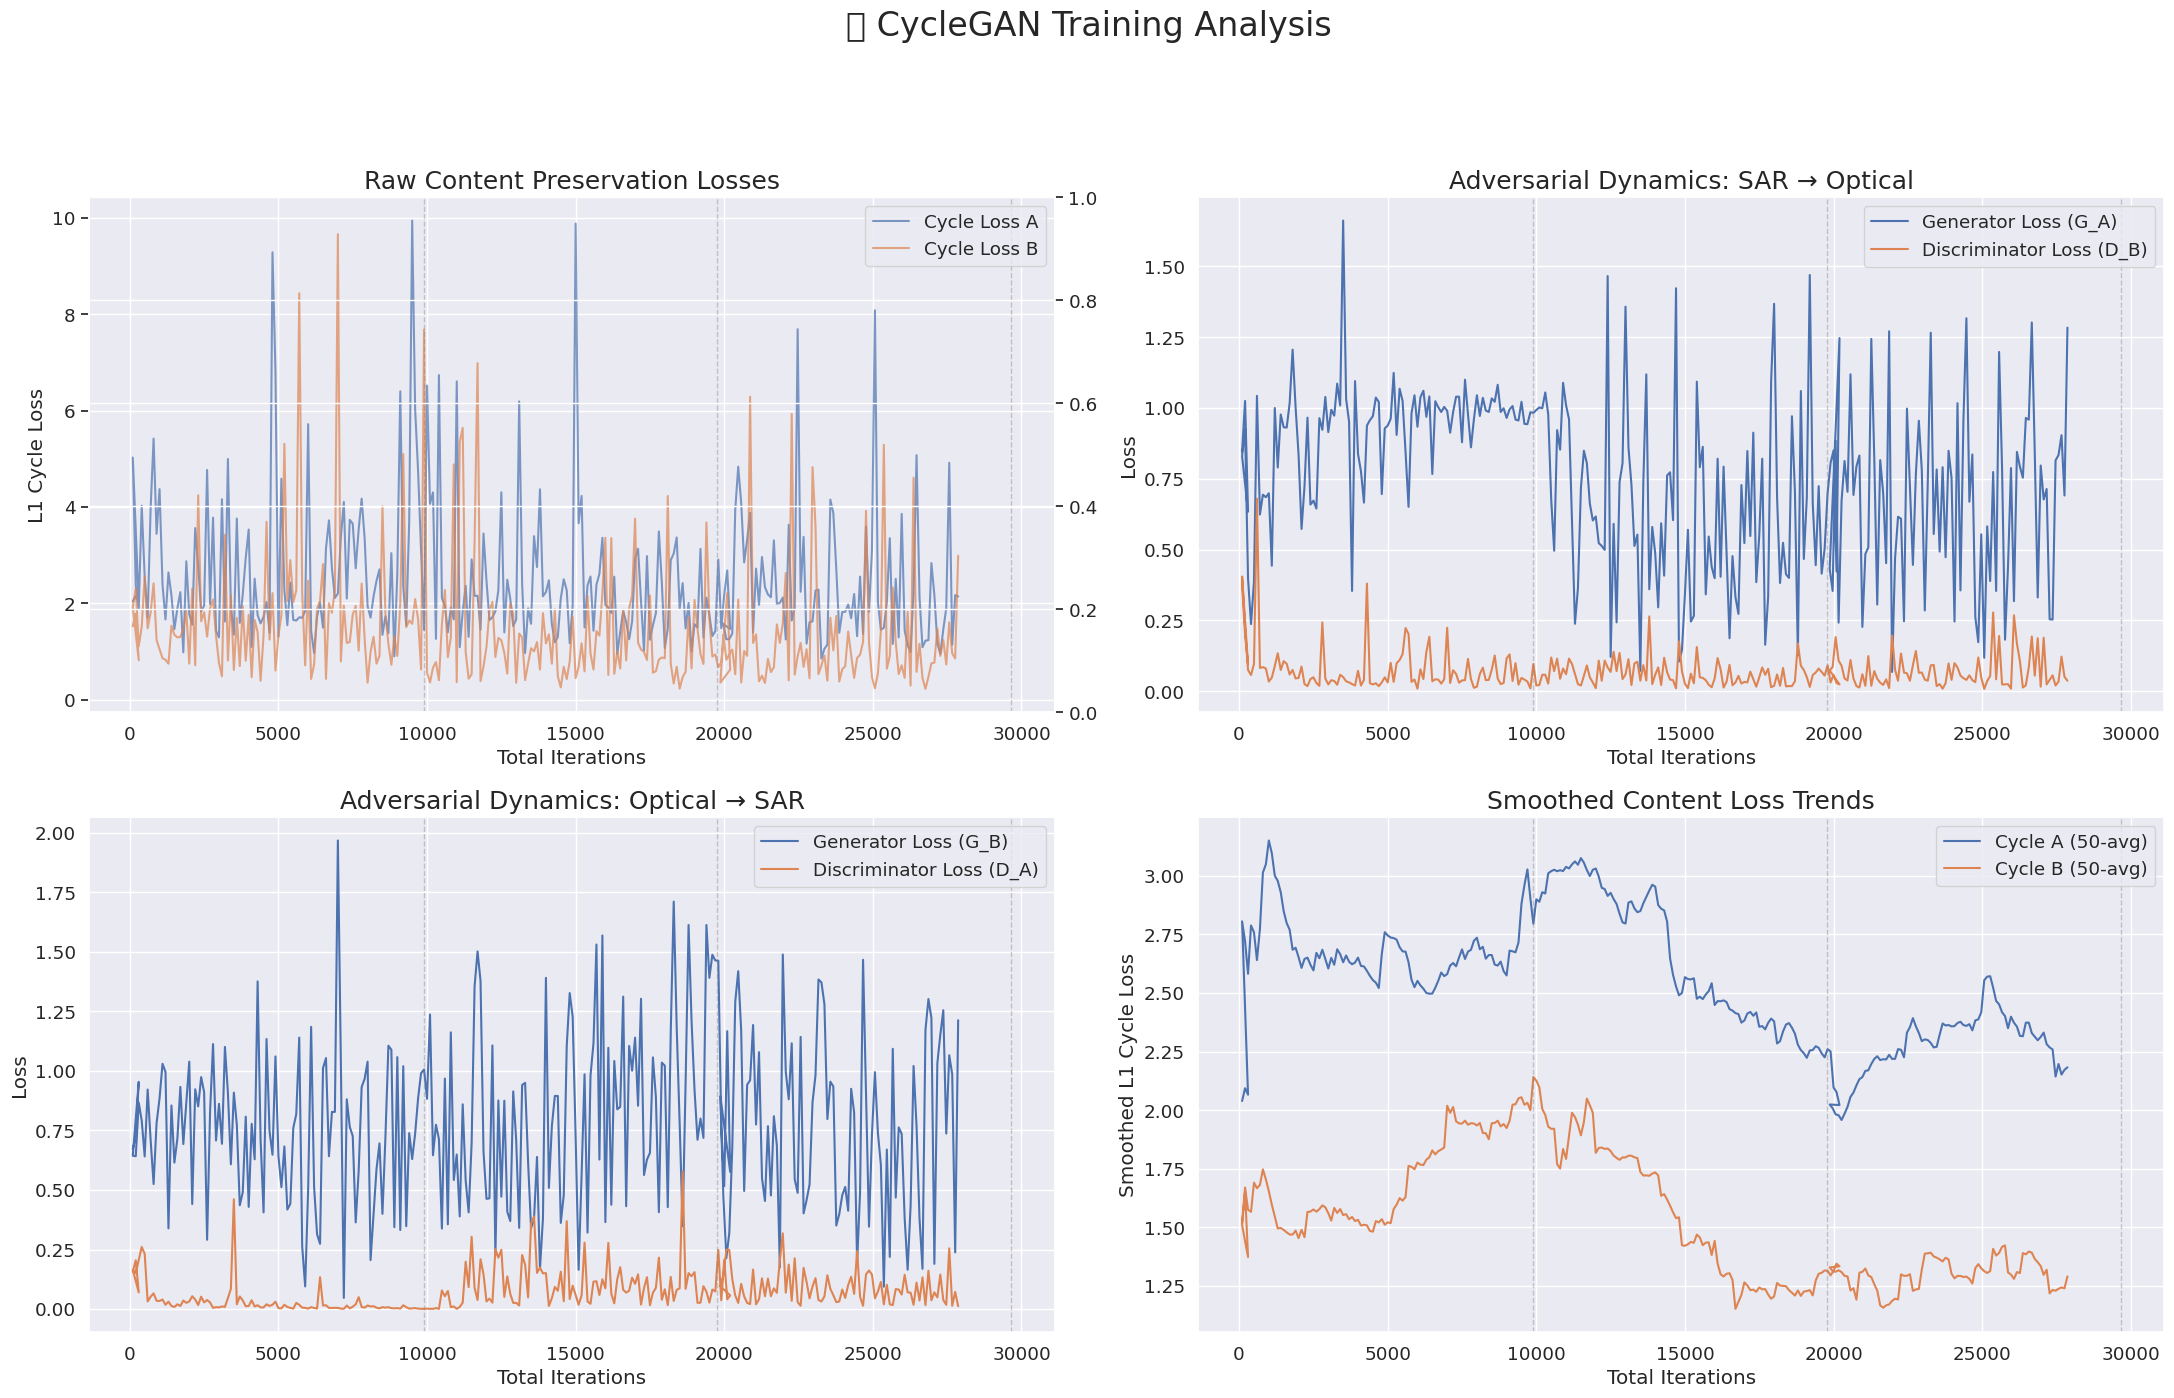

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- ⚙️ CONFIGURATION ---
# Path to your log file
log_file_path = "/content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix/checkpoints/sar2rgb_perceptual/loss_log.txt"
# --- END CONFIGURATION ---


# --- Data Loading ---
try:
    with open(log_file_path, 'r') as f:
        log_data = f.read()
    print(f"✅ Successfully loaded log file from: {log_file_path}")
except FileNotFoundError:
    print(f"❌ Error: Log file not found. Please check the path.")
    log_data = ""


# --- Data Parsing ---
if log_data:
    pattern = re.compile(
        r"epoch: (?P<epoch>\d+), iters: (?P<iters>\d+).*?"
        r"D_A: (?P<D_A>[\d.]+) G_A: (?P<G_A>[\d.]+) cycle_A: (?P<cycle_A>[\d.]+).*?"
        r"D_B: (?P<D_B>[\d.]+) G_B: (?P<G_B>[\d.]+) cycle_B: (?P<cycle_B>[\d.]+)"
        r"(?: perceptual: (?P<perceptual>[\d.]+))?"
    )

    data = []
    for line in log_data.strip().split('\n'):
        match = pattern.search(line)
        if match:
            data.append(match.groupdict())

    if not data:
        print("❌ Error: Could not find any valid loss data in the log file.")
    else:
        df = pd.DataFrame(data)
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        ITERS_PER_EPOCH = 1977
        df['total_iters'] = (df['epoch'] - 1) * ITERS_PER_EPOCH + df['iters']

        # --- Plotting ---
        sns.set(style="darkgrid", font_scale=1.2)
        fig, axes = plt.subplots(2, 2, figsize=(22, 14))
        fig.suptitle('📈 CycleGAN Training Analysis', fontsize=24, y=1.03)

        def draw_epoch_lines(ax, total_iters, epoch_interval=5, color='gray', alpha=0.4):
            max_iter = total_iters.max()
            for i in range(0, int(max_iter) + ITERS_PER_EPOCH, ITERS_PER_EPOCH * epoch_interval):
                if i > 0:
                    ax.axvline(i, linestyle='--', color=color, alpha=alpha, linewidth=1)

        # 1. Raw Content Preservation Losses
        ax1 = axes[0, 0]
        ax1_twin = ax1.twinx()
        p1, = ax1.plot(df['total_iters'], df['cycle_A'], label='Cycle Loss A', color='C0', alpha=0.7)
        p2, = ax1.plot(df['total_iters'], df['cycle_B'], label='Cycle Loss B', color='C1', alpha=0.7)
        ax1.set_title('Raw Content Preservation Losses', fontsize=18)
        ax1.set_xlabel('Total Iterations')
        ax1.set_ylabel('L1 Cycle Loss')
        handles = [p1, p2]

        if 'perceptual' in df.columns and not df['perceptual'].isnull().all():
            p3, = ax1_twin.plot(df['total_iters'], df['perceptual'], label='Perceptual Loss', color='C2', linestyle=':')
            ax1_twin.set_ylabel('Perceptual Loss (VGG)')
            handles.append(p3)

        draw_epoch_lines(ax1, df['total_iters'])
        ax1.legend(handles=handles, loc='upper right')

        # 2. Adversarial Losses (SAR → Optical)
        ax2 = axes[0, 1]
        ax2.plot(df['total_iters'], df['G_A'], label='Generator Loss (G_A)')
        ax2.plot(df['total_iters'], df['D_B'], label='Discriminator Loss (D_B)')
        ax2.set_title('Adversarial Dynamics: SAR → Optical', fontsize=18)
        ax2.set_xlabel('Total Iterations')
        ax2.set_ylabel('Loss')
        draw_epoch_lines(ax2, df['total_iters'])
        ax2.legend()

        # 3. Adversarial Losses (Optical → SAR)
        ax3 = axes[1, 0]
        ax3.plot(df['total_iters'], df['G_B'], label='Generator Loss (G_B)')
        ax3.plot(df['total_iters'], df['D_A'], label='Discriminator Loss (D_A)')
        ax3.set_title('Adversarial Dynamics: Optical → SAR', fontsize=18)
        ax3.set_xlabel('Total Iterations')
        ax3.set_ylabel('Loss')
        draw_epoch_lines(ax3, df['total_iters'])
        ax3.legend()

        # 4. Smoothed Content Loss Trends
        ax4 = axes[1, 1]
        window_size = 50
        p1_smooth, = ax4.plot(df['total_iters'], df['cycle_A'].rolling(window=window_size, min_periods=1).mean(), label=f'Cycle A ({window_size}-avg)', color='C0')
        p2_smooth, = ax4.plot(df['total_iters'], df['cycle_B'].rolling(window=window_size, min_periods=1).mean(), label=f'Cycle B ({window_size}-avg)', color='C1')
        ax4.set_title('Smoothed Content Loss Trends', fontsize=18)
        ax4.set_xlabel('Total Iterations')
        ax4.set_ylabel('Smoothed L1 Cycle Loss')
        handles_smooth = [p1_smooth, p2_smooth]

        if 'perceptual' in df.columns and not df['perceptual'].isnull().all():
            ax4_twin = ax4.twinx()
            p3_smooth, = ax4_twin.plot(df['total_iters'], df['perceptual'].rolling(window=window_size, min_periods=1).mean(), label=f'Perceptual ({window_size}-avg)', color='C2', linestyle='--')
            ax4_twin.set_ylabel('Smoothed Perceptual Loss')
            handles_smooth.append(p3_smooth)

        draw_epoch_lines(ax4, df['total_iters'])
        ax4.legend(handles=handles_smooth, loc='upper right')

        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()

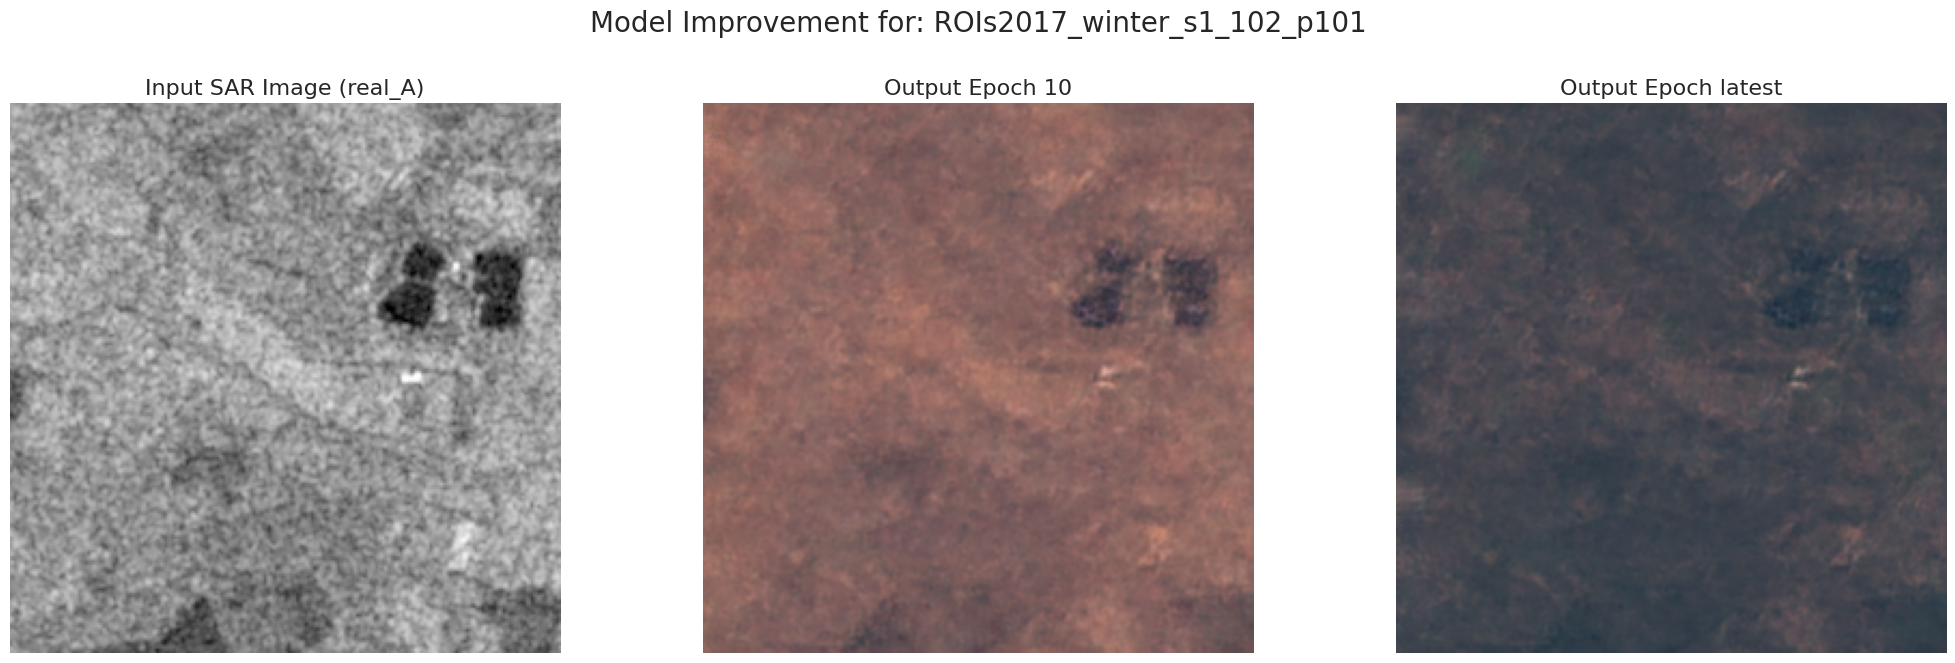

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# --- ⚙️ CONFIGURATION ---
# 1. The name of your training experiment.
EXPERIMENT_NAME = 'sar2rgb_perceptual'

# 2. The base name of the image you want to see.
IMAGE_BASENAME = 'ROIs2017_winter_s1_102_p101'

# 3. The two epochs you want to compare.
EPOCH_A = 10
EPOCH_B = 'latest'
# --- END CONFIGURATION ---


# --- Path Setup ---
results_dir = f"./results/{EXPERIMENT_NAME}/"
# The real_A is the same, so we just grab it from the first epoch's test results
real_A_path = os.path.join(results_dir, f"test_{EPOCH_A}", "images", f"{IMAGE_BASENAME}_real_A.png")
fake_B_A_path = os.path.join(results_dir, f"test_{EPOCH_A}", "images", f"{IMAGE_BASENAME}_fake_B.png")
fake_B_B_path = os.path.join(results_dir, f"test_{EPOCH_B}", "images", f"{IMAGE_BASENAME}_fake_B.png")

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle(f'Model Improvement for: {IMAGE_BASENAME}', fontsize=20)

try:
    # 1. Original Input SAR (real_A)
    img_real_A = mpimg.imread(real_A_path)
    axes[0].imshow(img_real_A)
    axes[0].set_title('Input SAR Image (real_A)', fontsize=16)
    axes[0].axis('off')

    # 2. Generated Output from Epoch A
    img_fake_B_A = mpimg.imread(fake_B_A_path)
    axes[1].imshow(img_fake_B_A)
    axes[1].set_title(f'Output Epoch {EPOCH_A}', fontsize=16)
    axes[1].axis('off')

    # 3. Generated Output from Epoch B
    img_fake_B_B = mpimg.imread(fake_B_B_path)
    axes[2].imshow(img_fake_B_B)
    axes[2].set_title(f'Output Epoch {EPOCH_B}', fontsize=16)
    axes[2].axis('off')

except FileNotFoundError as e:
    print(f"❌ Error: Could not find an image file. Please check your configuration and make sure you have run the test script for both epochs.")
    print(f"Missing file: {e.filename}")
    for ax in axes:
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

/content/drive/MyDrive/cyclegans_new/pytorch-CycleGAN-and-pix2pix


❌ Error: Could not find an image file. Please check your configuration and make sure you have run the test script for both epochs.
Missing file: ./results/sar2rgb_perceptual/test_20/images/ROIs2017_winter_s1_102_p100_fake_B.png


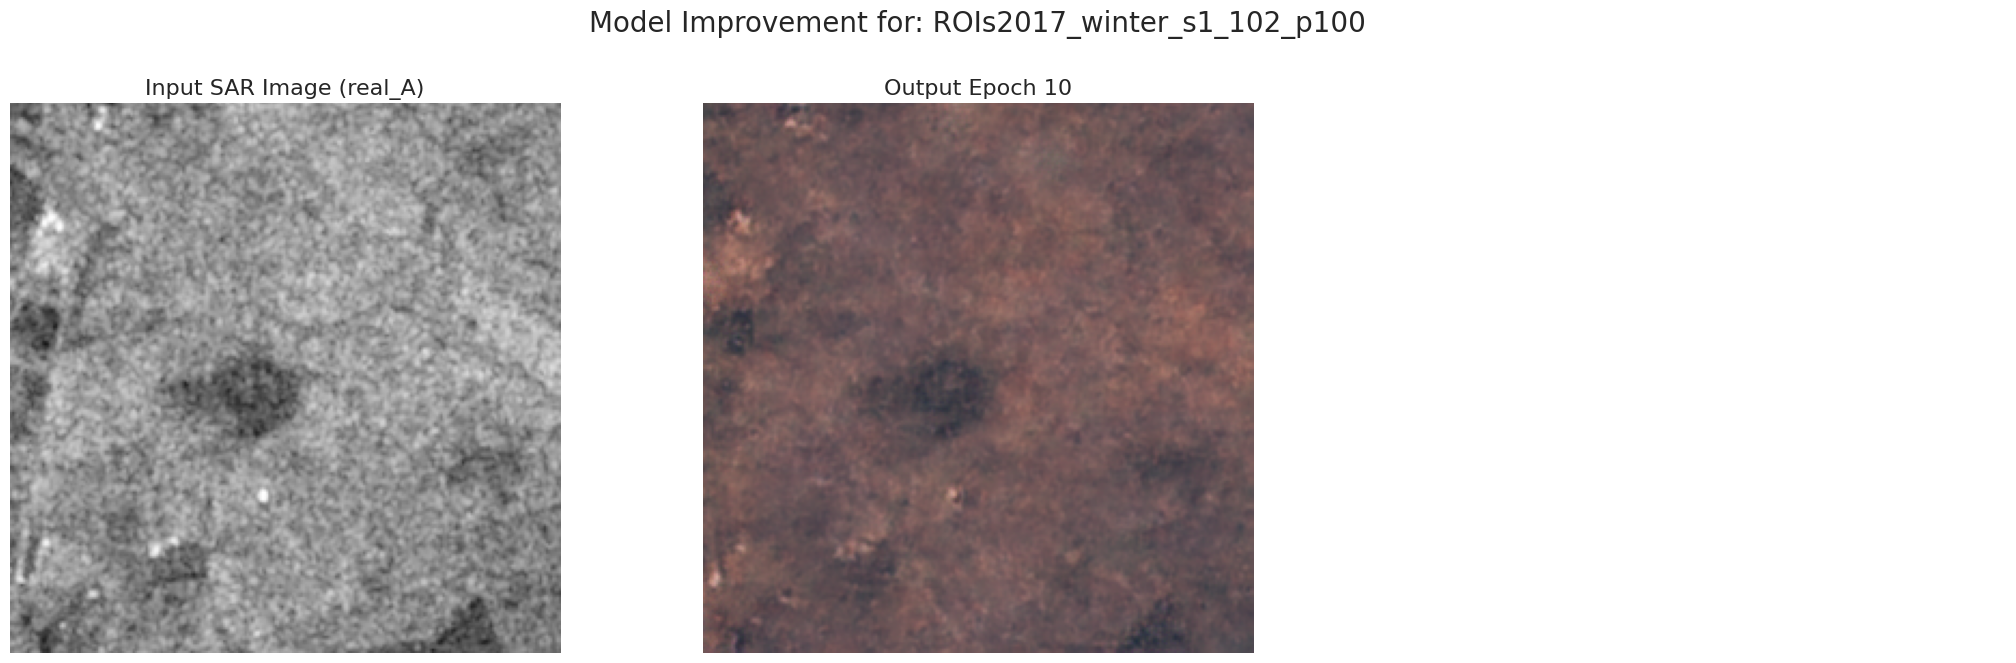

In [ ]:
!ls ./results/sar2rgb_perceptual/test_10/images/ROIs2017_winter_s1_102_p100_real_A.png

ls: cannot access './results/sar2rgb_perceptual/test_10/images/ROIs2017_winter_s1_102_p100_real_A.png': No such file or directory


In [ ]:
!pwd

/content


In [ ]:
%%writefile evaluate.py
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# --- Configuration ---
EPOCH_TO_EVALUATE = '5'
EXPERIMENT_NAME = 'sar2rgb_perceptual'
GENERATED_DIR = f"./results/{EXPERIMENT_NAME}/test_{EPOCH_TO_EVALUATE}/images/"
GROUND_TRUTH_DIR = "/content/drive/MyDrive/cyclegans/pytorch-CycleGAN-and-pix2pix/preprocessed_test_data/eo_ground_truth_rgb"
# ---
def evaluate_model(generated_dir, ground_truth_dir):
    if not os.path.exists(generated_dir):
        print(f"❌ Error: Generated images directory not found at '{generated_dir}'")
        return

    # test.py saves images with a _fake_B.png suffix for CycleGAN
    generated_files = [f for f in os.listdir(generated_dir) if f.endswith('_fake_B.png')]
    if not generated_files:
        print(f"❌ Error: Found 0 images with the '_fake_B.png' suffix in '{generated_dir}'. Please check the folder and filenames.")
        return

    print(f"Found {len(generated_files)} generated images. Starting evaluation...")
    psnr_scores, ssim_scores = [], []

    for fname in tqdm(generated_files, desc="Evaluating Images"):
        generated_path = os.path.join(generated_dir, fname)
        generated_image = cv2.cvtColor(cv2.imread(generated_path), cv2.COLOR_BGR2RGB)

        # Construct the corresponding ground truth filename
        gt_fname = fname.replace('_s1_', '_s2_').replace('_fake_B.png', '.npy')
        gt_path = os.path.join(ground_truth_dir, gt_fname)

        if os.path.exists(gt_path):
            gt_npy = np.load(gt_path)
            # De-normalize from [-1, 1] to [0, 255]
            gt_image = ((gt_npy + 1) / 2.0 * 255.0).astype(np.uint8)

            # Calculate metrics
            current_ssim = ssim(gt_image, generated_image, channel_axis=2, data_range=255)
            current_psnr = psnr(gt_image, generated_image, data_range=255)
            ssim_scores.append(current_ssim)
            psnr_scores.append(current_psnr)

    if ssim_scores:
        print("\n--- Final Evaluation Results ---")
        print(f"Epoch Tested: {EPOCH_TO_EVALUATE}")
        print(f"Images Evaluated: {len(ssim_scores)}")
        print(f"Average SSIM: {np.mean(ssim_scores):.4f} (Closer to 1 is better)")
        print(f"Average PSNR: {np.mean(psnr_scores):.4f} dB (Higher is better)")
        print("--------------------------------")

if __name__ == "__main__":
    evaluate_model(GENERATED_DIR, GROUND_TRUTH_DIR)

Overwriting evaluate.py


In [ ]:
!python evaluate.py

Found 400 generated images. Starting evaluation...
Evaluating Images: 100% 400/400 [02:30<00:00,  2.65it/s]

--- Final Evaluation Results ---
Epoch Tested: 10
Images Evaluated: 400
Average SSIM: 0.4984 (Closer to 1 is better)
Average PSNR: 18.0490 dB (Higher is better)
--------------------------------


#BEST ACCURACY AT 13TH EPOCH


In [ ]:
!python evaluate.py

Found 400 generated images. Starting evaluation...
Evaluating Images: 100% 400/400 [00:42<00:00,  9.41it/s]

--- Final Evaluation Results ---
Epoch Tested: latest
Images Evaluated: 400
Average SSIM: 0.5612 (Closer to 1 is better)
Average PSNR: 19.5543 dB (Higher is better)
--------------------------------


In [ ]:
!python evaluate.py

Found 446 generated images. Starting evaluation...
Evaluating Images: 100% 446/446 [00:36<00:00, 12.13it/s]

--- Final Evaluation Results ---
Epoch Tested: 5
Images Evaluated: 400
Average SSIM: 0.5109 (Closer to 1 is better)
Average PSNR: 20.0870 dB (Higher is better)
--------------------------------
